In [41]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from numpy import percentile

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV


import imblearn
from imblearn.over_sampling import SMOTE

from ftplib import FTP
import ftplib
import os
import socket
import sys


In [2]:
df = pd.read_csv("localweatherdf.csv")
df.head()

Unnamed: 0             datetime  humidity  pressure  temperature  \
0           0  2012-10-01 12:00:00       NaN       NaN          NaN   
1           1  2012-10-01 13:00:00      88.0    1009.0    61.664000   
2           2  2012-10-01 14:00:00      87.0    1009.0    61.654987   
3           3  2012-10-01 15:00:00      86.0    1009.0    61.629113   
4           4  2012-10-01 16:00:00      85.0    1009.0    61.603238   

   wind_direction  wind_speed       weather  
0             NaN         NaN           NaN  
1           150.0         2.0    light rain  
2           147.0         2.0  sky is clear  
3           141.0         2.0  sky is clear  
4           135.0         2.0  sky is clear

In [3]:
def fah_to_celcius(x):
    celcius = 5/9 * (x-32)
    return celcius

In [4]:
df["temperature.csv"] = df["temperature"].apply(fah_to_celcius)

In [5]:
# (H) - Humidity in percentage
# (T) - Temperature in Farenheit
# (WD) - Wind Direction in Degrees
# (WS)- Wind Speed in mph

In [6]:
df.columns

Index(['Unnamed: 0', 'datetime', 'humidity', 'pressure', 'temperature',
       'wind_direction', 'wind_speed', 'weather', 'temperature.csv'],
      dtype='object')

In [7]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [8]:
df.shape

(45253, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         45253 non-null  object 
 1   humidity         44311 non-null  float64
 2   pressure         44438 non-null  float64
 3   temperature      44460 non-null  float64
 4   wind_direction   44459 non-null  float64
 5   wind_speed       44459 non-null  float64
 6   weather          44460 non-null  object 
 7   temperature.csv  44460 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.8+ MB


In [10]:
df1 = df.copy()

In [11]:
df1.drop(["datetime","weather"],axis=1,inplace=True)

In [12]:
# Handling Outliers

In [13]:
z_scores = stats.zscore(df1)
# calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df1[filtered_entries]

In [14]:
q25, q75 = percentile(df1["humidity"], 25), percentile(df1["humidity"], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df1["humidity"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Percentiles: 25th=nan, 75th=nan, IQR=nan
Identified outliers: 0


In [15]:
# Filling missing values

In [16]:
df1["datetime"] = df["datetime"]
df1["weather"] = df["weather"]

In [17]:
df1.columns

Index(['humidity', 'pressure', 'temperature', 'wind_direction', 'wind_speed',
       'temperature.csv', 'datetime', 'weather'],
      dtype='object')

In [18]:
df2 = df1.copy()

In [19]:
df2["humidity"] = df2["humidity"].fillna(df2["humidity"].median())
df2["pressure"] = df2["pressure"].fillna(df2["pressure"].median())
df2["temperature"] = df2["temperature"].fillna(df2["temperature"].median())
df2["wind_direction"] = df2["wind_direction"].fillna(df2["wind_direction"].median())
df2["wind_speed"] = df2["wind_speed"].fillna(df2["wind_speed"].median())
df2["weather"]=df2["weather"].fillna(method ='pad')

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   humidity         45253 non-null  float64
 1   pressure         45253 non-null  float64
 2   temperature      45253 non-null  float64
 3   wind_direction   45253 non-null  float64
 4   wind_speed       45253 non-null  float64
 5   temperature.csv  44460 non-null  float64
 6   datetime         45253 non-null  object 
 7   weather          45252 non-null  object 
dtypes: float64(6), object(2)
memory usage: 2.8+ MB


In [21]:
df2["weather"] = df2["weather"].fillna(df2["weather"].mode())

In [22]:
# Scaling

In [23]:
numeric_cols = ["humidity","pressure","temperature","wind_direction","wind_speed"]
scaler = MinMaxScaler().fit(df2[numeric_cols])
df2.loc[:,numeric_cols]=scaler.transform(df2.loc[:,numeric_cols])

In [24]:
x = df2.loc[:,["temperature","pressure","wind_speed"]]
y = df2["weather"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100, stratify=y)

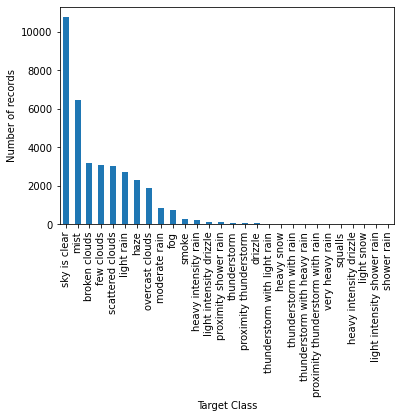

In [26]:
count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

Class=20, n=13447 (29.715%)
Class=10, n=3403 (7.520%)
Class=4, n=2908 (6.426%)
Class=18, n=3769 (8.329%)
Class=14, n=2360 (5.215%)
Class=0, n=4006 (8.852%)
Class=12, n=8074 (17.842%)
Class=2, n=3835 (8.475%)
Class=3, n=920 (2.033%)
Class=16, n=90 (0.199%)
Class=8, n=187 (0.413%)
Class=13, n=1062 (2.347%)
Class=23, n=102 (0.225%)
Class=6, n=257 (0.568%)
Class=24, n=24 (0.053%)
Class=15, n=173 (0.382%)
Class=5, n=9 (0.020%)
Class=7, n=49 (0.108%)
Class=1, n=71 (0.157%)
Class=26, n=28 (0.062%)
Class=25, n=51 (0.113%)
Class=27, n=11 (0.024%)
Class=17, n=13 (0.029%)
Class=9, n=8 (0.018%)
Class=21, n=377 (0.833%)
Class=19, n=3 (0.007%)
Class=22, n=9 (0.020%)
Class=11, n=7 (0.015%)


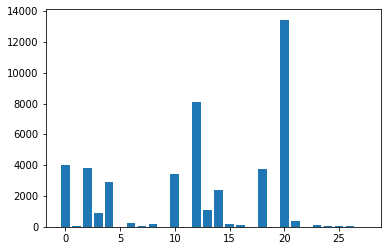

In [27]:
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Class=20, n=13447 (3.571%)
Class=10, n=13447 (3.571%)
Class=4, n=13447 (3.571%)
Class=18, n=13447 (3.571%)
Class=14, n=13447 (3.571%)
Class=0, n=13447 (3.571%)
Class=12, n=13447 (3.571%)
Class=2, n=13447 (3.571%)
Class=3, n=13447 (3.571%)
Class=16, n=13447 (3.571%)
Class=8, n=13447 (3.571%)
Class=13, n=13447 (3.571%)
Class=23, n=13447 (3.571%)
Class=6, n=13447 (3.571%)
Class=24, n=13447 (3.571%)
Class=15, n=13447 (3.571%)
Class=5, n=13447 (3.571%)
Class=7, n=13447 (3.571%)
Class=1, n=13447 (3.571%)
Class=26, n=13447 (3.571%)
Class=25, n=13447 (3.571%)
Class=27, n=13447 (3.571%)
Class=17, n=13447 (3.571%)
Class=9, n=13447 (3.571%)
Class=21, n=13447 (3.571%)
Class=19, n=13447 (3.571%)
Class=22, n=13447 (3.571%)
Class=11, n=13447 (3.571%)


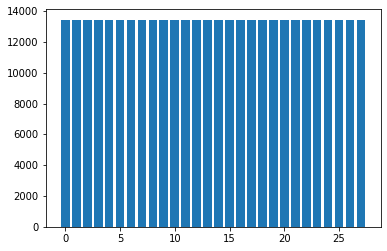

In [28]:
oversample = SMOTE(k_neighbors=2)
X, y = oversample.fit_resample(x, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
rf_training_accuracy = accuracy_score(y_train,rf_model.predict(X_train))
print(rf_training_accuracy)
rf_testing_accuracy = accuracy_score(y_test,rf_model.predict(X_test))
print(rf_testing_accuracy)

0.9961555316521254
0.816517050887071


### Hyperparameters

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 15, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [31]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [32]:
# rf_random.best_params_

In [33]:
# accuracy = accuracy_score(y_test,rf_random.predict(X_test))
# accuracy

In [34]:
rf_bestparams_model = RandomForestClassifier(n_estimators= 12,
 min_samples_split=5,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 70,
 bootstrap= False,random_state=42)

In [35]:
rf_bestparams_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=70, max_features='sqrt',
                       min_samples_split=5, n_estimators=12, random_state=42)

In [36]:
accuracy_best_params_training = accuracy_score(y_train,rf_bestparams_model.predict(X_train))
accuracy_best_params_testing = accuracy_score(y_test,rf_bestparams_model.predict(X_test))

In [37]:
print("Training accuracy",accuracy_best_params_training)
print("Testing accuracy",accuracy_best_params_testing)

Training accuracy 0.9643506898795533
Testing accuracy 0.8186417720174227


In [42]:
HOSTNAME= "hamiddleware.centralindia.cloudapp.azure.com"
USERNAME = "newftpuser"
PASSWORD = "^&XW8ARccie76"

try:
    ftp = FTP(HOSTNAME)
except(socket.error,socket.gaierror):
    print('cannot reach to %s' % HOSTNAME)
    print("Connect to ftp server")

ftp.encoding = "utf-8"

ftp.login(USERNAME,PASSWORD)

try:
        ftp.login(USERNAME,PASSWORD)
        print ("logged on to the ftp server")
except ftplib.error_perm:
        print('cannot login anonymously')
        ftp.quit()
        print ("logged on to the ftp server")
    
ftp.login(USERNAME,PASSWORD)

try:
        ftp.cwd("/home/newftpuser/ftp/upload/retail_pov")
        print("'250 Directory successfully changed.'")
except ftplib.error_perm:
        print('550 Failed to change directory')
#         ftp.quit()
        print ("Please try again")

filematch = '*.csv'

files = []

# try:
#     files = ftp.nlst(filematch)
# except ftp.error_perm as resp:
#     if str(resp) == "550 No files found":
#         print("No files in this directory")
#     else:
#         raise
# data = []
# for f in files:
# #     print(f)
#     data.append(f)

files = ["retail-pov-store-data_09-03-2022 17:00.csv","localevents_09-03-2022 17:00.csv",
            "publicholidays_09-03-2022 17:00.csv","weather_09-03-2022 17:00.csv"]

# import time
# import datetime
# today_format = datetime.datetime.today().strftime('%d-%m-%Y')
# print (today_format)
# # exp_date = str(today_format + datetime.timedelta(days=365)).split(" ")
# # exp = exp_date[0]
# # print (exp)
# # print(today_format.date())
# time = "17:00"

# new_filenames = []
# updated_file_name = []
# for filename in files:
#     filename = filename.split("_")
#     new_filenames.append(filename)
# #     print(filename)
#     for filename in new_filenames:
#         filename = filename[0] + "_" + str(today_format) + " " + time
#         updated_file_name.append(filename)
#     print(filename)
        
retail_pov_files = []
try:
    for filename in files:
        with open(filename, "wb") as file:
# 	# Command for Downloading the file "RETR filename"
            ftp.retrbinary(f"RETR {filename}", file.write)
        print("File succesfully downloaded")
        retail_pov_files.append(filename)
    print(retail_pov_files)
except ftplib.error_perm:
        print('550 Failed to open the file')
#         ftp.quit()
        print ("Please try again")

# with open(filename, "wb") as file:
# # 	# Command for Downloading the file "RETR filename"
#     ftp.retrbinary(f"RETR {filename}", file.write)


ftp.quit()

logged on to the ftp server
'250 Directory successfully changed.'
File succesfully downloaded
File succesfully downloaded
File succesfully downloaded
File succesfully downloaded
['retail-pov-store-data_09-03-2022 17:00.csv', 'localevents_09-03-2022 17:00.csv', 'publicholidays_09-03-2022 17:00.csv', 'weather_09-03-2022 17:00.csv']


'221 Goodbye.'

In [43]:
weather_data = pd.read_csv(retail_pov_files[3])
weather_data.head()

Geography    State                 Date  Temperature  Pressure  \
0        US  Arizona  24-02-2022 12:02:00         22.3    1015.0   
1        US  Arizona  25-02-2022 12:02:00         21.6    1015.0   
2        US  Arizona  26-02-2022 12:02:00         22.1    1017.0   
3        US  Arizona  27-02-2022 12:02:00         22.5    1018.0   
4        US  Arizona  28-02-2022 12:02:00         21.7    1018.0   

         Showers  Wind Speed  
0           Mist         4.7  
1           Mist         5.0  
2         Cloudy         6.1  
3  Partly cloudy         5.4  
4  Partly cloudy         5.4

In [44]:
test_df = pd.DataFrame()

In [45]:
test_df["Temperature"] = weather_data["Temperature"]
test_df["Pressure"] = weather_data["Pressure"]
test_df["Wind Speed"] = weather_data["Temperature"]

In [46]:
test_result = rf_bestparams_model.predict(test_df)

In [47]:
test_result

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])